In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm
import scipy.signal as signal
import time
import warnings
warnings.filterwarnings('ignore')
import copy

from data_preprocessing_revise import data_processing, split_train_test, input_target
from data_preprocessing_revise import input_target_grouping, input_target_grouping_1d
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

file_list = [i.replace('\\','/') for i in sorted(glob(f"c3d/*txt"))]
file_name = []
for i in file_list:
    file, _, _ = os.path.basename(i).split('.')
    file_name.append(file)
    
FORCE, ANGLE, JOINT = data_processing(file_list, file_name)
player_trial, train, test = split_train_test(JOINT, random = 5)
DOM = {}
for session in JOINT:
    if session.split('_')[0] in test:
        df = JOINT[session]
        dominant = df['dominant'][0]
        DOM[session] = dominant

411it [00:15, 26.26it/s]


In [12]:
inputs_sc, targets = input_target(JOINT, FORCE, train, test,joint_cut_off = 13.4, force_cut_off = 60)

In [13]:
fp = 'lead'
kfolds = KFold(n_splits=9, shuffle=True, random_state=3)
for fold, (t, v) in enumerate(kfolds.split(train)):
    if fold == 1:
        break
    tr = list(np.array(train)[t])
    va = list(np.array(train)[v])
    k_fold_since = time.time()
    train_sessions = list(inputs_sc['train'][fp])
    trn = []
    val = []
    for session in train_sessions:
        if session.split('_')[0] in tr:
            trn.append(session)
        elif session.split('_')[0] in va:
            val.append(session)

In [15]:
lead_input = pd.DataFrame()
lead_target = pd.DataFrame()
rear_input = pd.DataFrame()
rear_target = pd.DataFrame()
for trial in targets['train']['lead']:
    idx = targets['train']['lead'][trial].index
    inputs_sc['train']['lead'][trial] = inputs_sc['train']['lead'][trial].loc[idx,:]
    lead_input = pd.concat([lead_input, inputs_sc['train']['lead'][trial]])
    lead_target = pd.concat([lead_target, targets['train']['lead'][trial]])
    
    idx = targets['train']['rear'][trial].index
    inputs_sc['train']['rear'][trial] = inputs_sc['train']['rear'][trial].loc[idx,:]
    rear_input = pd.concat([rear_input, inputs_sc['train']['rear'][trial]])
    rear_target = pd.concat([rear_target, targets['train']['rear'][trial]])

lead_y_true = {}
rear_y_true = {}
for trial in targets['test']['lead']:
    idx = targets['test']['lead'][trial].index
    inputs_sc['test']['lead'][trial] = inputs_sc['test']['lead'][trial].loc[idx,:].reset_index(drop=True)
    targets['test']['lead'][trial] = targets['test']['lead'][trial].reset_index(drop=True)
    targets['test']['lead'][trial].columns = ['AP Force','ML Force','Vertical Force']    
    lead_y_true[trial] = targets['test']['lead'][trial]
    
    idx = targets['test']['rear'][trial].index
    inputs_sc['test']['rear'][trial] = inputs_sc['test']['rear'][trial].loc[idx,:].reset_index(drop=True)
    targets['test']['rear'][trial] = targets['test']['rear'][trial].reset_index(drop=True)
    targets['test']['rear'][trial].columns = ['AP Force','ML Force','Vertical Force']
    rear_y_true[trial] = targets['test']['rear'][trial]

In [16]:
from sklearn.linear_model import LinearRegression
model_lead = LinearRegression()
model_rear = LinearRegression()
model_lead.fit(lead_input, lead_target)
model_rear.fit(rear_input, rear_target)

LinearRegression()

In [17]:
lead_y_pred = {}
rear_y_pred = {}

for trial in inputs_sc['test']['lead']:
    lead_pred = model_lead.predict(inputs_sc['test']['lead'][trial])
    rear_pred = model_rear.predict(inputs_sc['test']['rear'][trial])
    
    lead_y_pred[trial] = pd.DataFrame(lead_pred, columns = ['AP Force','ML Force','Vertical Force'])
    rear_y_pred[trial] = pd.DataFrame(rear_pred, columns = ['AP Force','ML Force','Vertical Force'])

In [18]:
lead_tn_y_true = {}
lead_tn_y_pred = {}
xr = []
yr = []
zr = []
xrmse = []
yrmse = []
zrmse = []
xnrmse = []
ynrmse = []
znrmse = []
smoothing = 1

import scipy.stats as stats
from tnorma import tnorma
for session in lead_y_pred:
    y_true = lead_y_true[session]
    y_pred = lead_y_pred[session]
    
    trn_y_true, b, a = tnorma(y_true,step=-101)
    lead_tn_y_true[session] = pd.DataFrame(trn_y_true, columns = y_true.columns)
    trn_y_pred, b, a = tnorma(y_pred,step=-101)
    lead_tn_y_pred[session] = pd.DataFrame(trn_y_pred, columns = y_pred.columns)
    
    xr.append(stats.pearsonr(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean())[0])
    yr.append(stats.pearsonr(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean())[0])
    zr.append(stats.pearsonr(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean())[0])
    
    xrmse.append(mean_squared_error(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean(),squared=False))
    yrmse.append(mean_squared_error(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean(),squared=False))
    zrmse.append(mean_squared_error(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean(),squared=False))
    
    xnrmse.append(100 * mean_squared_error(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['AP Force'].max() - y_true['AP Force'].min()))
    ynrmse.append(100 * mean_squared_error(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['ML Force'].max() - y_true['ML Force'].min()))
    znrmse.append(100 * mean_squared_error(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['Vertical Force'].max() - y_true['Vertical Force'].min()))


R | X : 0.797 (0.203), Y : 0.726 (0.229), Z : 0.919 (0.074)
RMSE | X : 20.89 (5.38), Y : 8.56 (2.80), Z : 24.42 (8.81)
NRMSE | X : 18.83 (6.80), Y : 27.19 (8.99), Z : 12.82 (3.54)


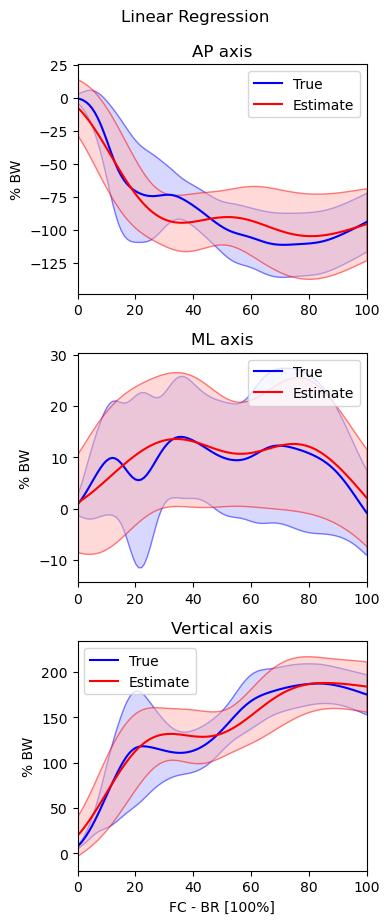

In [19]:
import spm1d
tn_pred = (np.concatenate([lead_tn_y_pred[session] for session in lead_tn_y_pred], axis=1)).T
tn_true = (np.concatenate([lead_tn_y_true[session] for session in lead_tn_y_true], axis=1)).T


fig, ax = plt.subplots(3,1, figsize= (4,9))
spm1d.plot.plot_mean_sd(tn_true[::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[0])
spm1d.plot.plot_mean_sd(tn_pred[::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[0])
ax[0].legend()
ax[0].set_title('AP axis')
ax[0].set_ylabel('% BW')
spm1d.plot.plot_mean_sd(tn_true[1::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[1])
spm1d.plot.plot_mean_sd(tn_pred[1::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[1])
ax[1].legend()
ax[1].set_title('ML axis')
ax[1].set_ylabel('% BW')
spm1d.plot.plot_mean_sd(tn_true[2::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[2])
spm1d.plot.plot_mean_sd(tn_pred[2::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[2])
ax[2].legend()
ax[2].set_title('Vertical axis')
ax[2].set_ylabel('% BW')
ax[2].set_xlabel('FC - BR [100%]')
plt.tight_layout()

plt.suptitle(f'Linear Regression',y=1.022)
plt.savefig(f'Regression_STRIDE.png',dpi=300,bbox_inches='tight')

print(f"R | X : {np.mean(xr):.3f} ({np.std(xr):.3f}), Y : {np.mean(yr):.3f} ({np.std(yr):.3f}), Z : {np.mean(zr):.3f} ({np.std(zr):.3f})")
print(f"RMSE | X : {np.mean(xrmse):.2f} ({np.std(xrmse):.2f}), Y : {np.mean(yrmse):.2f} ({np.std(yrmse):.2f}), Z : {np.mean(zrmse):.2f} ({np.std(zrmse):.2f})")
print(f"NRMSE | X : {np.mean(xnrmse):.2f} ({np.std(xnrmse):.2f}), Y : {np.mean(ynrmse):.2f} ({np.std(ynrmse):.2f}), Z : {np.mean(znrmse):.2f} ({np.std(znrmse):.2f})")

In [20]:
rear_tn_y_true = {}
rear_tn_y_pred = {}
xr = []
yr = []
zr = []
xrmse = []
yrmse = []
zrmse = []
xnrmse = []
ynrmse = []
znrmse = []
smoothing = 1

import scipy.stats as stats
from tnorma import tnorma
for session in rear_y_true:
    y_true = rear_y_true[session]
    y_pred = rear_y_pred[session]
    
    trn_y_true, b, a = tnorma(y_true,step=-101)
    rear_tn_y_true[session] = pd.DataFrame(trn_y_true, columns = y_true.columns)
    trn_y_pred, b, a = tnorma(y_pred,step=-101)
    rear_tn_y_pred[session] = pd.DataFrame(trn_y_pred, columns = y_pred.columns)
    
    xr.append(stats.pearsonr(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean())[0])
    yr.append(stats.pearsonr(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean())[0])
    zr.append(stats.pearsonr(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean())[0])
    
    xrmse.append(mean_squared_error(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean(),squared=False))
    yrmse.append(mean_squared_error(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean(),squared=False))
    zrmse.append(mean_squared_error(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean(),squared=False))
    
    xnrmse.append(100 * mean_squared_error(y_true['AP Force'], y_pred['AP Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['AP Force'].max() - y_true['AP Force'].min()))
    ynrmse.append(100*mean_squared_error(y_true['ML Force'], y_pred['ML Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['ML Force'].max() - y_true['ML Force'].min()))
    znrmse.append(100*mean_squared_error(y_true['Vertical Force'], y_pred['Vertical Force'].ewm(span=smoothing).mean(),squared=False) / (y_true['Vertical Force'].max() - y_true['Vertical Force'].min()))

R | X : 0.965 (0.027), Y : 0.820 (0.129), Z : 0.960 (0.042)
RMSE | X : 9.96 (4.57), Y : 4.75 (2.41), Z : 18.03 (15.25)
NRMSE | X : 15.58 (8.58), Y : 18.76 (8.64), Z : 18.79 (20.53)


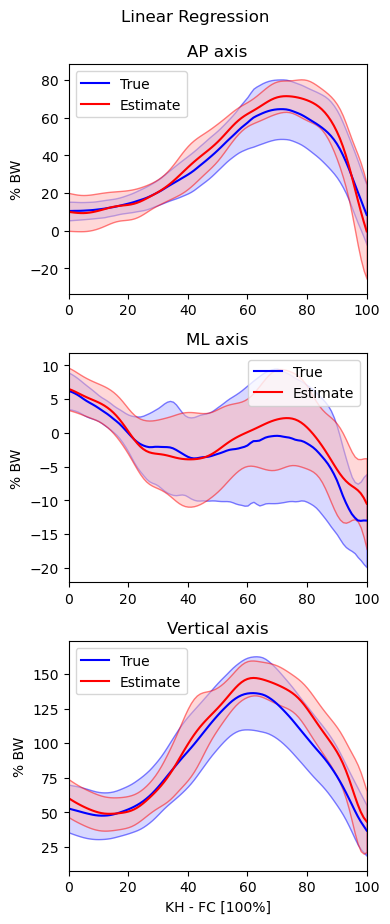

In [21]:
import spm1d
tn_pred = (np.concatenate([rear_tn_y_pred[session] for session in rear_tn_y_pred], axis=1)).T
tn_true = (np.concatenate([rear_tn_y_true[session] for session in rear_tn_y_true], axis=1)).T


fig, ax = plt.subplots(3,1, figsize= (4,9))
spm1d.plot.plot_mean_sd(tn_true[::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[0])
spm1d.plot.plot_mean_sd(tn_pred[::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[0])
ax[0].legend()
ax[0].set_title('AP axis')
ax[0].set_ylabel('% BW')
spm1d.plot.plot_mean_sd(tn_true[1::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[1])
spm1d.plot.plot_mean_sd(tn_pred[1::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[1])
ax[1].legend()
ax[1].set_title('ML axis')
ax[1].set_ylabel('% BW')
spm1d.plot.plot_mean_sd(tn_true[2::3, :], linecolor='b', lw= 1.5,facecolor=(0.7,0.7,1), edgecolor='b', label='True', ax=ax[2])
spm1d.plot.plot_mean_sd(tn_pred[2::3, :], linecolor='r', lw= 1.5, facecolor=(1,0.7,0.7), edgecolor='r', label='Estimate', ax=ax[2])
ax[2].legend()
ax[2].set_title('Vertical axis')
ax[2].set_ylabel('% BW')
ax[2].set_xlabel('KH - FC [100%]')
plt.tight_layout()
plt.suptitle(f'Linear Regression',y=1.022)
plt.savefig(f'Regression_DRIVE.png',dpi=300,bbox_inches='tight')

print(f"R | X : {np.mean(xr):.3f} ({np.std(xr):.3f}), Y : {np.mean(yr):.3f} ({np.std(yr):.3f}), Z : {np.mean(zr):.3f} ({np.std(zr):.3f})")
print(f"RMSE | X : {np.mean(xrmse):.2f} ({np.std(xrmse):.2f}), Y : {np.mean(yrmse):.2f} ({np.std(yrmse):.2f}), Z : {np.mean(zrmse):.2f} ({np.std(zrmse):.2f})")
print(f"NRMSE | X : {np.mean(xnrmse):.2f} ({np.std(xnrmse):.2f}), Y : {np.mean(ynrmse):.2f} ({np.std(ynrmse):.2f}), Z : {np.mean(znrmse):.2f} ({np.std(znrmse):.2f})")

# R | X : 0.9568 (0.0395), Y : 0.7838 (0.1451), Z : 0.9783 (0.0134) = 2